In [1]:
#
# sci kit classifiers notebook
#

# for Colab paths
# import sys
# sys.path.append('/content/')
#
#!nvidia-smi
#!nvidia-smi -q
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx

import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, Compose
from LandmarkDataset import LandmarkDataset
from torch.utils.data.sampler import SubsetRandomSampler
torch.set_default_dtype(torch.float64)





device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformations = Compose([
    Lambda(lambda x: torch.tensor(x.values).to(device))
])
target_transformations = Compose([
    Lambda(lambda x: torch.tensor(x).to(device))
])

dataset = LandmarkDataset("/home/jovyan/train/data",
                          "/home/jovyan/model",
                          transform=transformations)

num_classes = dataset.num_class
input_size = dataset.input_size() #2 * (21 * 3) + 12 + 1 + 10 #149 + 1 label -> 150
 
data = np.empty( (len(dataset), input_size), dtype=np.float64)
labels = np.empty( len(dataset), dtype = int)
                  
for i, d in enumerate(dataset):
    data[i] = np.array(d[1], dtype=np.float64)
    labels[i] = np.round(d[0]).astype(int) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("Train len: ", len(X_train))
print("Validation len: ", len(X_test))

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cm_zo_o4 because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train len:  28976
Validation len:  7244


model init
Last supported opset: 18
--------------------


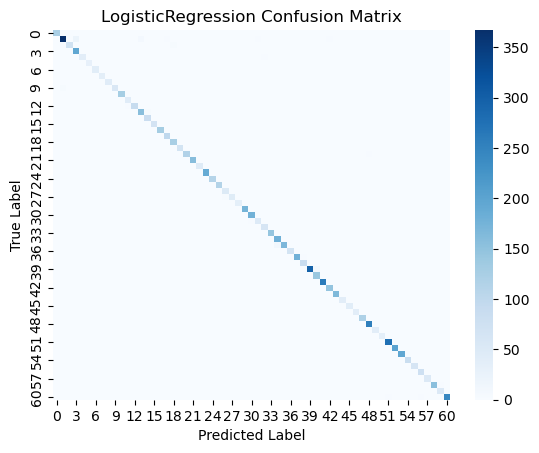

LogisticRegression accuracy: 0.984
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       126
           1       0.98      0.90      0.94       408
           2       1.00      0.92      0.96        78
           3       0.90      0.99      0.95       196
           4       1.00      0.93      0.96        42
           5       1.00      1.00      1.00        31
           6       0.98      1.00      0.99        41
           7       0.97      0.97      0.97        39
           8       1.00      1.00      1.00        42
           9       1.00      0.95      0.97        60
          10       1.00      1.00      1.00       129
          11       0.96      0.98      0.97        44
          12       1.00      0.98      0.99        91
          13       0.95      0.98      0.96       161
          14       0.96      1.00      0.98        85
          15       1.00      1.00      1.00        68
          16       1.00 

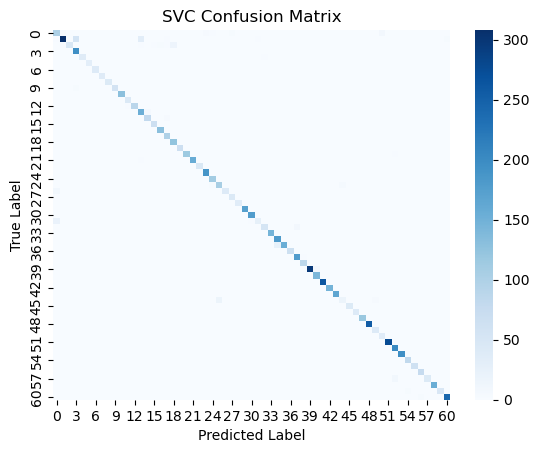

SVC accuracy: 0.955
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.81      0.78       126
           1       0.98      0.75      0.85       408
           2       1.00      0.63      0.77        78
           3       0.77      1.00      0.87       196
           4       1.00      0.90      0.95        42
           5       1.00      1.00      1.00        31
           6       0.98      0.98      0.98        41
           7       1.00      0.97      0.99        39
           8       1.00      1.00      1.00        42
           9       0.98      0.95      0.97        60
          10       1.00      1.00      1.00       129
          11       0.94      1.00      0.97        44
          12       1.00      0.98      0.99        91
          13       0.81      0.95      0.87       161
          14       0.91      0.95      0.93        85
          15       0.97      1.00      0.99        68
          16       0.98      1.00      

In [2]:
# Initialize the models
print("model init")

#
# Both Decision + RandomForest classifiers have export issues with running on onnx runtime web js
#
#   * DecisionTreeClassifer: no raw probabilities; difficult to apply an in-game threshold / cutoff value
#   * RandomForestClassifier: typically most accurate but not by that much to overcome the gargantuan model file size 
#   * LogisticRegression: just as accurate as any of the others, smallest file size
#   * SVC: decent, but large file size (11mb) vs LogisticRegression
#   * GaussianNB: extremely inaccurate, ignored for now.
#
# "Simple" LogisticRegession seems best for this class of probem.
#
# Most models (except GaussianNB) had 90%+ accuracy, so evaluating much better than two layer NN.
# But these also lack dropout, so not completely comparable.
#

models = [
    LogisticRegression(max_iter=10000),
    #DecisionTreeClassifier(),
    #RandomForestClassifier(),
    SVC(probability=True),
    #GaussianNB()
]

from skl2onnx import __max_supported_opset__
print("Last supported opset:", __max_supported_opset__)


# Train and test each model, and compute the accuracy score
for model in models:
    
    print("--------------------")
    
    # Train the model
    model.fit(X_train, y_train)

    # Test the model and compute the accuracy score
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
 
    # Eval visuals
    cm = confusion_matrix(y_test, y_pred)    
    labels = dataset.class_map.keys()
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=False, cmap='Blues', fmt='g')
    plt.title(f"{model.__class__.__name__} Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Print the model's name and accuracy score
    print(model.__class__.__name__, "accuracy: {:.3f}".format(accuracy) )
    print("Classification Report")
    print( classification_report(y_test, y_pred) )
    print("------------")
    
    #
    # Exports
    #
    
    # Export Onnx
    model_onnx = to_onnx(model, X=X_train, options={LogisticRegression: {'zipmap': False}, SVC: {'zipmap': False}})
    
    filename_onnx = f"./export/model_onnx_{model.__class__.__name__}.onnx"
    print(f"Exporting {filename_onnx}")
    
    with open(filename_onnx, "wb") as f:
        f.write(model_onnx.SerializeToString())
        
    model_onnx = onnx.load(filename_onnx)
    onnx.checker.check_model(filename_onnx)
    
    # Export Scikit
    filename_scikit = f"./export/model_scikit_{model.__class__.__name__}.pkl"
    print(f"Exporting {filename_scikit}")
    joblib.dump(model, filename_scikit, compress=9)

In [3]:
print("DONE")

DONE
